# Project Statement:

## Marina Pier Inc. is leveraging technology to automate their operations on the San Francisco port.

## The company’s management has set out to build a bias-free/ corruption-free automatic system that reports & avoids faulty situations caused by human error. Examples of human error include misclassifying the correct type of boat. The type of boat that enters the port region is as follows

* Buoy
* Cruise_ship
* Ferry_boat
* Freight_boar
* Gondola
* Inflatable_boat
* Kayak
* Paper_boat
* Sailboat

## Marina Pier wants to use Deep Learning techniques to build an automatic reporting system that recognizes the boat. The company is also looking to use a transfer learning approach of any lightweight pre-trained model in order to deploy in mobile devices.

## As a deep learning engineer, your task is to:

1. Build a CNN network to classify the boat.
2. Build a lightweight model with the aim of deploying the solution on a mobile device using transfer learning. You can use any lightweight pre-trained model as the initial (first) layer. MobileNetV2 is a popular lightweight pre-trained model built using Keras API.

# Dataset and Data Description: 

## The dataset folder is called Automating_Port_Operations_dataset 

## The dataset contains images of 9 types of boats. It contains a total of 1162 images. The training images are provided in the directory of the specific class itself. 
## Classes:
* ferry_boat
* gondola
* sailboat
* cruise_ship
* kayak
* inflatable_boat
* paper_boat
* buoy
* freight_boat




In [8]:
#pip install tensorflow

# Importing necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import glob

# Defining the path for the dataset and displaying first image from each image directory

['buoy', 'gondola', 'ferry_boat', 'cruise_ship', 'freight_boat', 'kayak', 'sailboat', 'inflatable_boat', 'paper_boat']
/Users/master/GitProjects/BoatClassification_CNN_and_TransferLearning_Project/Automating_Port_Operations_dataset

Displaying first image from folder: buoy


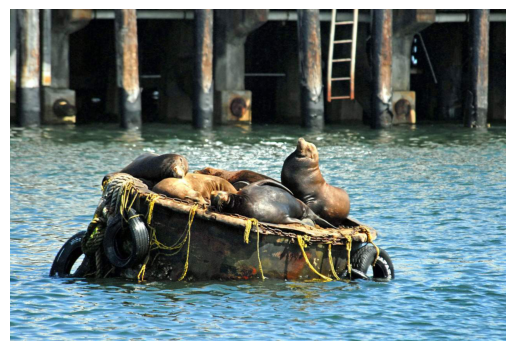

Displaying first image from folder: gondola


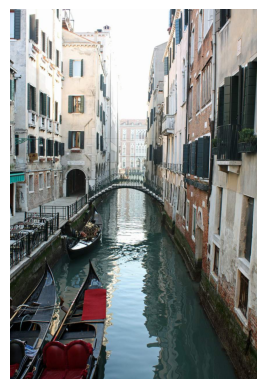

Displaying first image from folder: ferry_boat


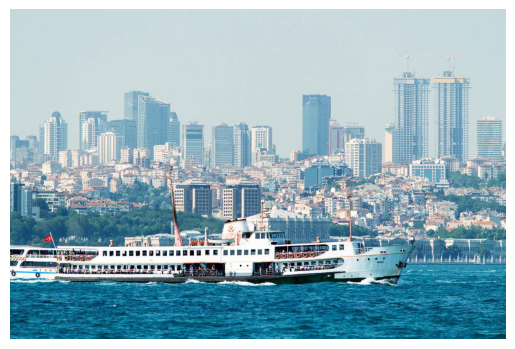

Displaying first image from folder: cruise_ship


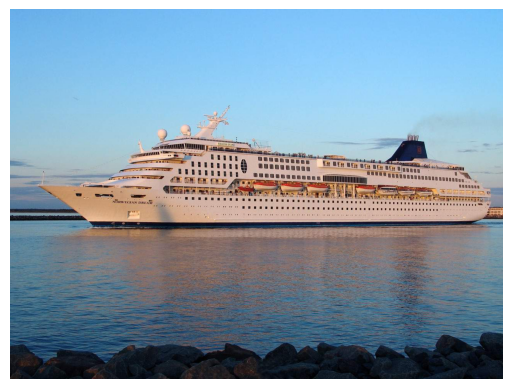

Displaying first image from folder: freight_boat


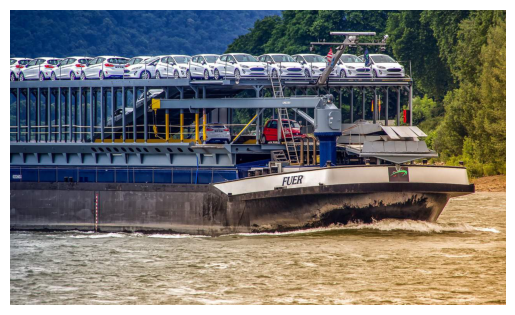

Displaying first image from folder: kayak


In [10]:

# Defining base path where dataset is located
data_dir = os.path.join(os.getcwd(), 'Automating_Port_Operations_dataset')

# Getting only visible directories (exclude hidden directories like .DS_Store)
image_dirs = [d for d in os.listdir(data_dir) if not d.startswith('.')]

print(image_dirs)
print(data_dir)
print()

# Function to display single image given an image path
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
# Displaying the first image in each directory in image_dirs
for d in image_dirs:
    image_path = os.path.join(data_dir, d, os.listdir(os.path.join(data_dir, d))[0])
    print(f"Displaying first image from folder: {d}")
    display_image(image_path)


# Creating training and datasets with following characteristics:

* Dataset will be split into train and test in the ratio 80:20, with shuffle and random state = 43
* We'll use tf.keras.preprocessing.image_dataset_from_directory to load the train and test datasets with data normalization

* We'll load train, validation and test dataset in batches of 32 using the function initialized in step above

## Dataset Split into Training, Validation and Testing with normalzation

In [ ]:
# Set parameters for training dataset
batch_size = 32
img_height = 150
img_width = 150
image_scale = 1./255  # Normalize pixel values to range [0, 1]

# Create training dataset: 80% train and 20% (validation + test) split
train_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # 80% for training, 20% for validation + test
  subset="training",
  seed=43,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

# Create 20% validation + test set
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 80% for training, 20% for validation + test
    subset="validation",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Further split val_test_ds into 50% validation and 50% test (resulting in 10% each)
val_batches = int(0.5 * len(val_test_ds))

# First 50% of val_test_ds is validation set
val_ds = val_test_ds.take(val_batches)

# Last 50% of val_test_ds is test set
test_ds = val_test_ds.skip(val_batches)

# Normalize the pixel values for all datasets
def normalize_img(image, label):
    image = image * image_scale  # Scale pixel values between 0 and 1
    return image, label
  
# Apply normalization to train, validation, and test datasets
train_ds = train_val_ds.map(normalize_img)
val_ds = val_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

# Prefetch data for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


print('Min and max pixel values in training dataset:')
image_batch, label_batch = next(iter(train_ds))
for i in range (0,image_batch.shape[0]):
    print(np.min(image_batch[i]), np.max(image_batch[i]))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

In [ ]:
# Import necessary modules from Keras
from tensorflow.keras import layers, models

class_names = train_val_ds.class_names
print(f"Class names: {class_names}")

# number of classes
num_classes = len(class_names)

# Data Augmentation (Remove input_shape from here)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])

# Define input shape using Input() layer explicitly
input_shape = (img_height, img_width, 3)

# Model architecture with explicit Input layer
model = models.Sequential([
    layers.Input(shape=input_shape),  # Use Input() to define the input shape
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)



In [ ]:
# New Block - Check dataset sizes and distribution

# Check the number of images in each dataset
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()
test_size = tf.data.experimental.cardinality(test_ds).numpy()

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

# Check that all the classes are represented in the training, validation, and test datasets
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

test_labels = []
for _, labels in test_ds:
    test_labels.extend(labels.numpy())

# Print the distribution of labels in each set
print(f"Training label distribution: {np.unique(train_labels, return_counts=True)}")
print(f"Validation label distribution: {np.unique(val_labels, return_counts=True)}")
print(f"Test label distribution: {np.unique(test_labels, return_counts=True)}")

# Check input/output shapes for each dataset
for images, labels in train_ds.take(1):
    print(f"Train images shape: {images.shape}, Train labels shape: {labels.shape}")

for images, labels in val_ds.take(1):
    print(f"Validation images shape: {images.shape}, Validation labels shape: {labels.shape}")

for images, labels in test_ds.take(1):
    print(f"Test images shape: {images.shape}, Test labels shape: {labels.shape}")


## Getting Class names

In [ ]:
class_names = train_val_ds.class_names
print(f"Class names: {class_names}")

## Visualizing images from training dataset

In [ ]:

# Load train dataset with cache properly applied for better performance
# We shuffle the dataset and repeat it just b
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=43,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Cache after shuffling and before repeating the dataset
train_ds = train_ds.shuffle(buffer_size=1000).cache().repeat()

# Prefetch to optimize performance
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)





In [ ]:
# Create an iterator over the dataset without using .take() method 
# which is used to get a specific number of batches, but is causing warnings

iterator = iter(train_ds)

# Get one batch from the dataset
images, labels = next(iterator)

# Plot the first 9 images from the batch
plt.figure(figsize=(50, 50))
for i in range(9):  # Displaying only 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontsize=50)
    plt.axis("off")
plt.show()


# Create Convolutional Neural Network Model

# We'll build a CNN network with Keras with the following layers:

### We'll do data augmentation issue to balance the data as we have some images that are 

### Conv2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
### Conv2D with 32 filters, kernel size 3,3, and activation relu, followed by MaxPool2D
### GLobalAveragePooling2D layer
### Dense layer with 128 neurons and activation relu
### Dense layer with 128 neurons and activation relu
### Dense layer with 9 neurons and activation softmax.


In [ ]:
'''''''''

# Data Augmentation

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical",  input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
])
'''''''''''''''
# number of classes
num_classes = len(class_names)

# Create model: 
# 1 Conv2D with 32 filters, 3x3 kernel size, and ReLU activation function followed by MaxPooling2D with 2x2 pool size
# 1 Conv2D with 64 filters, 3x3 kernel size, and ReLU activation function followed by MaxPooling2D with 2x2 pool size
# 1 GlobalAveragePooling2D layer
# 1 Dense layer with 128 neurons and ReLU activation function
# 1 Dense layer with 128 neurons and ReLU activation function
# 1 Dense layer with num_classes neurons and softmax activation function for classification

from tensorflow.keras import layers, models

# Define the input shape
input_shape = (150, 150, 3)

# Create the model
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Adding Input layer explicitly
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Print the model summary
model.summary()



Compile the model with Adam optimizer, categorical_crossentropy loss, and with metrics accuracy, precision, and recall.
Train the model for 20 epochs and plot training loss and accuracy against epochs.
Evaluate the model on test images and print the test loss and accuracy.
Plot heatmap of the confusion matrix and print classification report.


In [ ]:
 # Compile the model with Adam optimizer, categorical crossentropy loss function,
# and accuracy, precision, recall, and F1 metrics
model.compile(optimizer='adam',
              loss="SparseCategoricalCrossentropy",
              metrics=['accuracy', 
                       tf.metrics.Precision(), 
                       tf.metrics.Recall()])

In [ ]:
# Train the model with 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

In [ ]:
num_classes = len(class_names)
print(num_classes)

for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


In [ ]:
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)


In [ ]:
print(f"Number of classes: {num_classes}")
